# Modeling Brain Dynamics Using the Virtual Brain (Using Individual Region-Specific HRF)

This study is along similar lines of the one at, https://github.com/mlion0200/educase_TVB_braintumor. 
However, here we represent the effect of incorporating Individual Region-Specific HRF. The TVB BOLD simulation considers a constant HRF throughout the connectome of an individual, and across individuals. This reduces the specificity of the model. In the present study, we intend to personalize the models to a greater depth by retrieving the HRF for each connectome (and each region of the connectome) through the empericical BOLD time-series.
The relevant additions to the TVB can be found at https://github.com/AmoghJohri/tvb-root/tree/amogh.

In [1]:
# loading libraries
import os
import sys
import csv
import scipy
import nitime
import warnings
import numpy as np
import scipy.io as sio
import scipy.stats as stat
import multiprocessing as mp
import matplotlib.pyplot as plt
from nitime.utils import percent_change
from nitime.timeseries import TimeSeries
from nitime.analysis import CorrelationAnalyzer, CoherenceAnalyzer

warnings.filterwarnings("ignore")

In [2]:
# The following two steps are required so that python does not search for tvb. imports in the installed version
path = os.getcwd() + "/tvb-root/scientific_library"
sys.path.insert(0, path)

from tvb.simulator.lab import *
from tvb.simulator.plot.tools import *
from tvb.analyzers import fmri_balloon
from tvb.datatypes.time_series import TimeSeriesRegion
from tvb.simulator.models.wong_wang_exc_inh import ReducedWongWangExcInh

LOG = get_logger('BrainTumor')

## Introduction

We show how to simulate neural mass model with the reduced Wong-Wang model, using the individual subject connectivity. The global model parameters of the Reduced Wong-Wang model are individually optimized to improve prediction accuracy of functional connectivity.
Original publication can be found here: https://www.eneuro.org/content/5/3/ENEURO.0083-18.2018

![Workflow](https://www.eneuro.org/content/eneuro/5/3/ENEURO.0083-18.2018/F1.large.jpg)

## Hemodynamic Response Function Retrieval
Instead of using a constant HRF, we retrieve the same through empirical region-wise BOLD time-series data(separately for each subject, and each brain region of the subject). For more information, visit: https://www.nitrc.org/projects/rshrf.

<hr style="border:2px solid gray"> </hr>

![Resting-State HRF Retrieval](https://guorongwu.github.io/HRF/deconv.jpg)

<hr style="border:2px solid gray"> </hr>
Here, we carry out the steps 1 and 2 as shown in the figure. The region-wise emperical time-series forms the input and the HRF is retrieved from the same. The consequent BOLD simulations are then mediated through the retrieved HRF.

## Input Files
For the purpose of this demonstration, we have a singular relevant directory **Input** with all that we are going to require.

The revelant files are:
* **connectivity.h5** - This contains all the relevant data for initializing a brain-model in TVB. The same has also been provided in .txt format in the Input directory. These correspond to:
    * *areas.txt*
    * *average_orientations.txt*
    * *centres.txt*
    * *cortical.txt*
    * *hemisphere.txt*
    * *tract_lengths.txt*
    * *weights.txt*
* **FC.txt** - This contains the empirical functional connectivity matrix for the subject.
* **ROIts.txt** - This contains the empirical region-wise BOLD time-series for the subject (input for retrieval of HRF).

All the other files are irrelevant to the current tutorial.

## Define the Connectivity

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


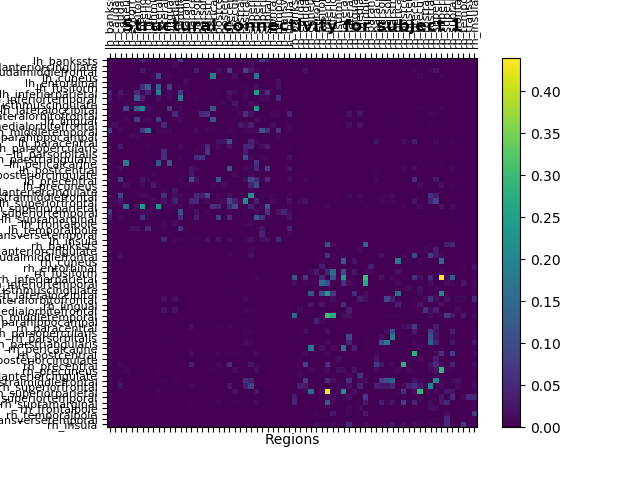

Text(0.5, 1.05, 'Structural connectivity for subject 1')

In [3]:
# Plot Structural Connectivity Info: A 2D plot for visualizing the Connectivity.weights matrix
%pylab nbagg
conn=connectivity.Connectivity.from_file(os.getcwd() + "/Input/connectivity.h5")
conn.configure()

# plot of structural connectivity
plot_connectivity(connectivity = conn, plot_tracts=False) 
plt.xlabel("Regions")
plt.ylabel("Regions")
connectivity_title = "Structural connectivity for subject " + "1"
plt.title(connectivity_title, fontweight="bold", fontsize="12", y = 1.05)

## Load Empirical Functional Connectivity matrix

In [4]:
# get empirical functional connectivity from FC.txt
em_fc_matrix = np.loadtxt(os.getcwd() + "/Input/FC.txt")

# indexes of all the values above the diagonal.
uidx = np.triu_indices(68, 1)

# Fisher-Z transform the correlations, important for standardization
em_fc_z = np.arctanh(em_fc_matrix)
# get the upper triangle since it is symmetric along diagonal
em_fc = em_fc_z[uidx]

## Configure the Simulator
Reduced Wong-Wang model with an excitatory and an inhibitory population, mutually coupled.
Following Deco et al 2014.
Table below shows parameters defined in Reduced Wong-Wang model, default value and description.

| Parameter Name | Default Value   | Description |
|--------------|-------------|-----------|
| a_e            | 310           | Excitatory population input gain parameter (n/C)       |
| b_e     | 125         | Excitatory population input shift parameter (Hz)     |
| d_e     | 0.16        | Excitatory population input scaling parameter (s)   |
| gamma_e | 0.641/1000  | Excitatory population kinetic parameter      |
| tau_e   | 100     | Excitatory population NMDA decay time constant (ms)      |
| w_p   | 1.4     | Excitatory population recurrence weight      |
| J_N   | 0.15     | NMDA current (nA)      |
| W_e   | 1.0     | Excitatory population external input scaling weight      |
| a_i   | 615     | Inhibitory population input gain parameter (n/C)      |
| b_i   | 177     | Inhibitory population input shift parameter (Hz)      |
| d_i   | 0.087     | Inhibitory population input scaling parameter (s)      |
| gamma_i   | 1.0/1000     | Inhibitory population kinetic parameter      |
| tau_i   | 10     | Inhibitory population NMDA decay time constant (ms)      |
| J_i   | 1.0     | Local inhibitory current (nA)      |
| I_o   | 0.382     | Effective external input (nA)      |
| G   | 2.0     | Global coupling scaling (To be optimized)      |
| lamda   | 0.0     | Inhibitory global coupling scaling      |

In [5]:
# set up the Reduced Wong-Wang model
# adjust the parameters to your needs, otherwise it will use the default value shown above
rww = ReducedWongWangExcInh()

## Comparitive Analysis
For the sake of comparision, we have branched out two experiments from this point.
1. Using TVB's default BOLD simulation (employing a constant HRF function.
2. Using region-specific HRF for each region for the convolution.

We shall proceed in the same order.

## Default BOLD Simulation

In [13]:
# set up the simulator
# adjust the simulation_length to your needs/ available computation time
# in the demo data, time resolution of 2100
# a simulation_length of 420,000
# the BOLD monitor in the simulator applies an HRF with convolution during simulation to generate BOLD time series
sim = simulator.Simulator(
    model=rww,
    connectivity=conn,
    coupling=coupling.Linear(),
    integrator=integrators.HeunStochastic(dt=1, noise=noise.Additive(nsig=np.array([1e-5]))), 
    monitors=(
        monitors.TemporalAverage(period=2100.0),
        monitors.Bold(period=2100)),
    simulation_length=420000
).configure()

In [7]:
# each iteration for the parameter space exploration corresponds to one full-execution of this function
def run_sim(global_coupling):
    # this is the parameter being adjusted for each iteration of simulation
    sim.coupling.a = global_coupling 
    
    # running the BOLD simulation
    (tavg_time, tavg_data), (bold_time, bold_data) = sim.run() 
    
    # obtaining the BOLD time-series
    tsr = bold_data[:, 0, :, 0].T
    
    # Time-series object for analysis
    T = TimeSeries(tsr, sampling_interval=2.1)
    T.metadata['roi'] = sim.connectivity.region_labels
    
    # Initialize the correlation analyzer
    C = CorrelationAnalyzer(T)
    sim_fc = np.arctanh(C.corrcoef)[uidx]
    
    # Calculate the link-wise Pearson correlation between individual’s 
    # upper triangular part of the simulated and empirical functional connectivity matrix
    pearson_corr, _ = stat.pearsonr(sim_fc, em_fc)

    return (global_coupling, pearson_corr)

## Parameter Space Exploration (Global Coupling Factor)

In [ ]:
# define global coupling range to explore in simulation
# in the original study a range from 0.01 to 3 with steps of 0.015 was explored
# NOTE: Too many steps will take very long time when running the script on a local computer
# adjust the range of G, or the step size to reduce simulation time
gc_range = np.arange(0.01, 3, 0.29)
gc_range = np.expand_dims(gc_range, axis = 0).T

# run simulation in parallel - be sure that your computer has enough cores
n_cores = 4 # specify number of cores which should be used in parallel 
p = mp.Pool(processes=n_cores)

results = p.map(run_sim, gc_range)
p.close()

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


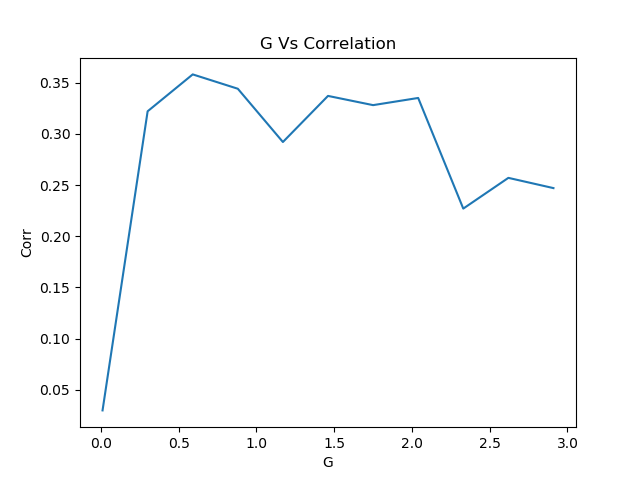

Text(0.5, 1.0, 'G Vs Correlation')

In [8]:
# Plot 
%pylab nbagg
g = []
PCorr = []
for result in results:
    g.append(result[0])
    PCorr.append(result[1])

plt.plot(g, PCorr)
plt.xlabel('G')
plt.ylabel('Corr')
plt.title('G Vs Correlation')

In [9]:
optimized_g = g[PCorr.index(max(PCorr))]
print("The optimized G for subject: " + str(optimized_g))
print("The optimized Pearson's R: " + str(max(PCorr)))

The optimized G for subject: 0.59
The optimized Pearson's R: 0.358


## BOLD Simulation with RestingStateHRF Kernel
For more information about the underlying details, refer to exploring_the_rsHRF_BOLD_Monitor.ipynb (in the same repository)

In [10]:
# set up the simulator (similar as above)
'''hrf_kernel has been set to RestingStateHRF where the roiTS (empirical BOLD time-series) 
has been provided as a numpy array'''
''' retrieval of HRF requires the information of HRF length (HRF_length) and BOLD Repetition Time (TR), 
the same has been provided while maintaining regularity with the simulator
NOTE: RestingStateHRF class takes input in seconds, where as the simulator takes input in milliseconds'''
sim = simulator.Simulator(
    model=rww,
    connectivity=conn,
    coupling=coupling.Linear(),
    integrator=integrators.HeunStochastic(dt=1, noise=noise.Additive(nsig=np.array([1e-5]))), 
    monitors=(
        monitors.TemporalAverage(period=2100.0),
        monitors.Bold(period=2100, hrf_length = 24, hrf_kernel = equations.RestingStateHRF(roiTS=np.loadtxt(os.getcwd() + "/Input/ROIts.txt"), TR = 2.1, HRF_length = 24.))),
    simulation_length=420000
).configure()

In [ ]:
# parameter space exploration for G
s = p.map(run_sim, gc_range)
p.close()

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


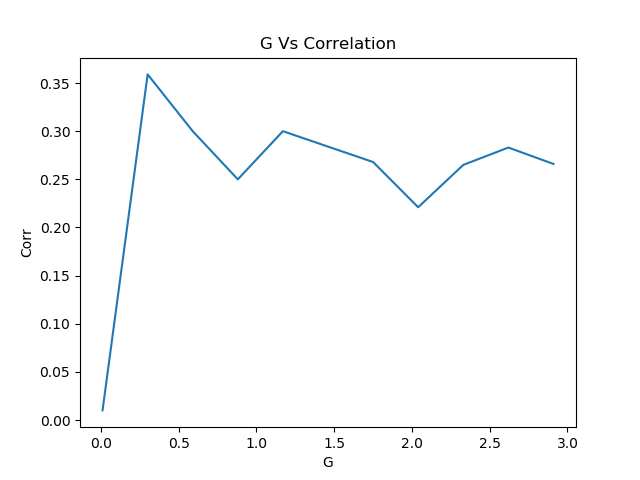

Text(0.5, 1.0, 'G Vs Correlation')

In [11]:
# Plot 
%pylab nbagg
g = []
PCorr = []
for result in results:
    g.append(result[0])
    PCorr.append(result[1])

plt.plot(g, PCorr)
plt.xlabel('G')
plt.ylabel('Corr')
plt.title('G Vs Correlation')

In [12]:
optimized_g = g[PCorr.index(max(PCorr))]
print("The optimized G for subject: " + str(optimized_g))
print("The optimized Pearson's R: " + str(max(PCorr)))

The optimized G for subject: 0.3
The optimized Pearson's R: 0.359


## References

> Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide,
Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013)
    The Virtual Brain: a simulator of primate brain network dynamics.
Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010)

> Guo-Rong Wu, Daniele Marinazzo. “Retrieving the Hemodynamic Response Function in resting state fMRI: methodology and applications.” PeerJ PrePrints, 2015.